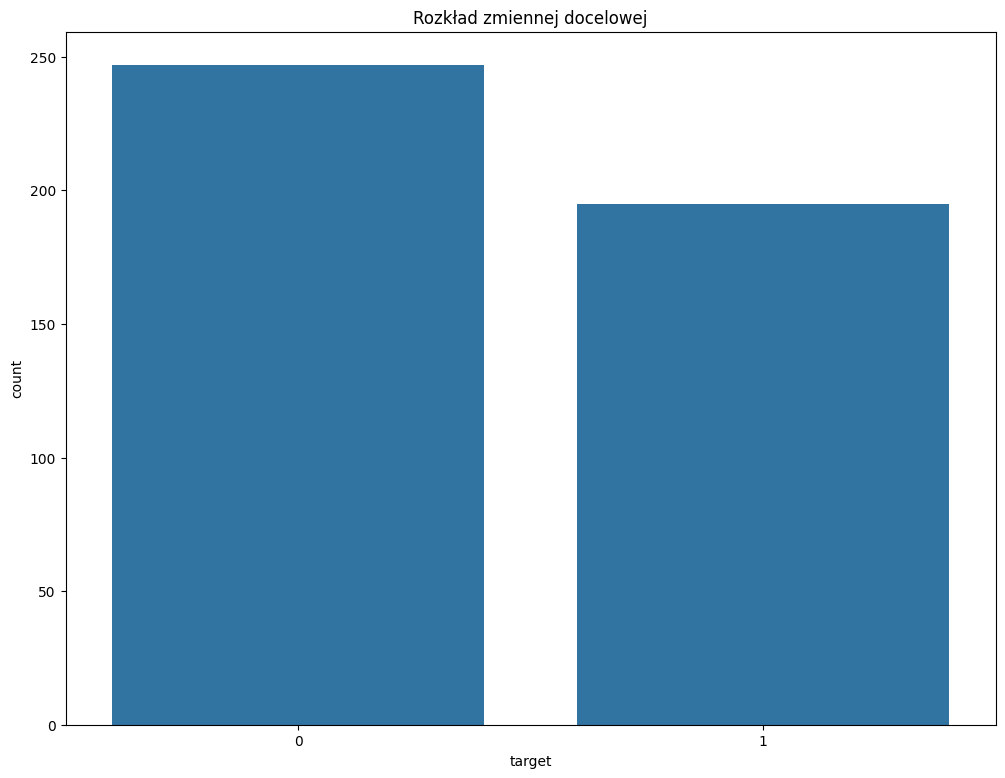

Rozmiar treningowy: (309, 10), Rozmiar testowy: (133, 10)
F1 Score (wszystkie cechy): 0.714


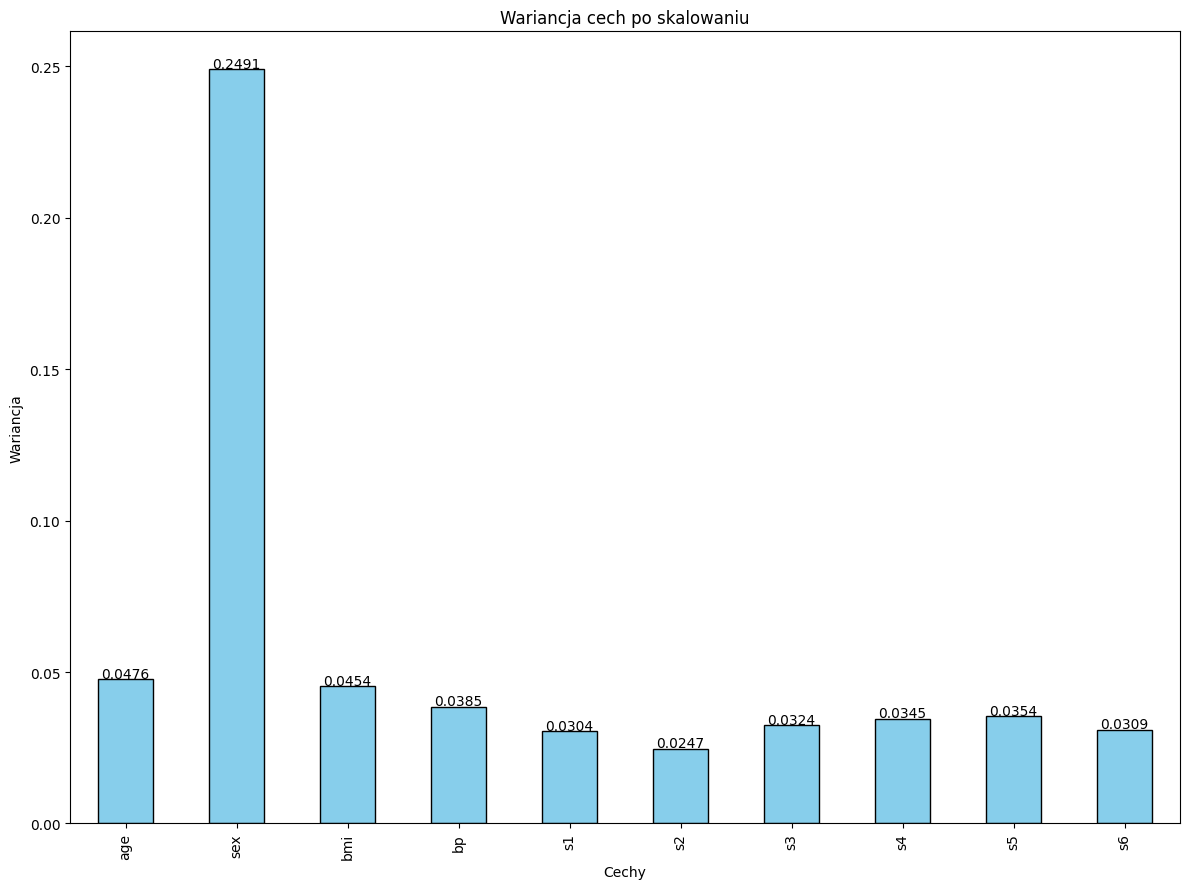

F1 Score (próg wariancji): 0.714


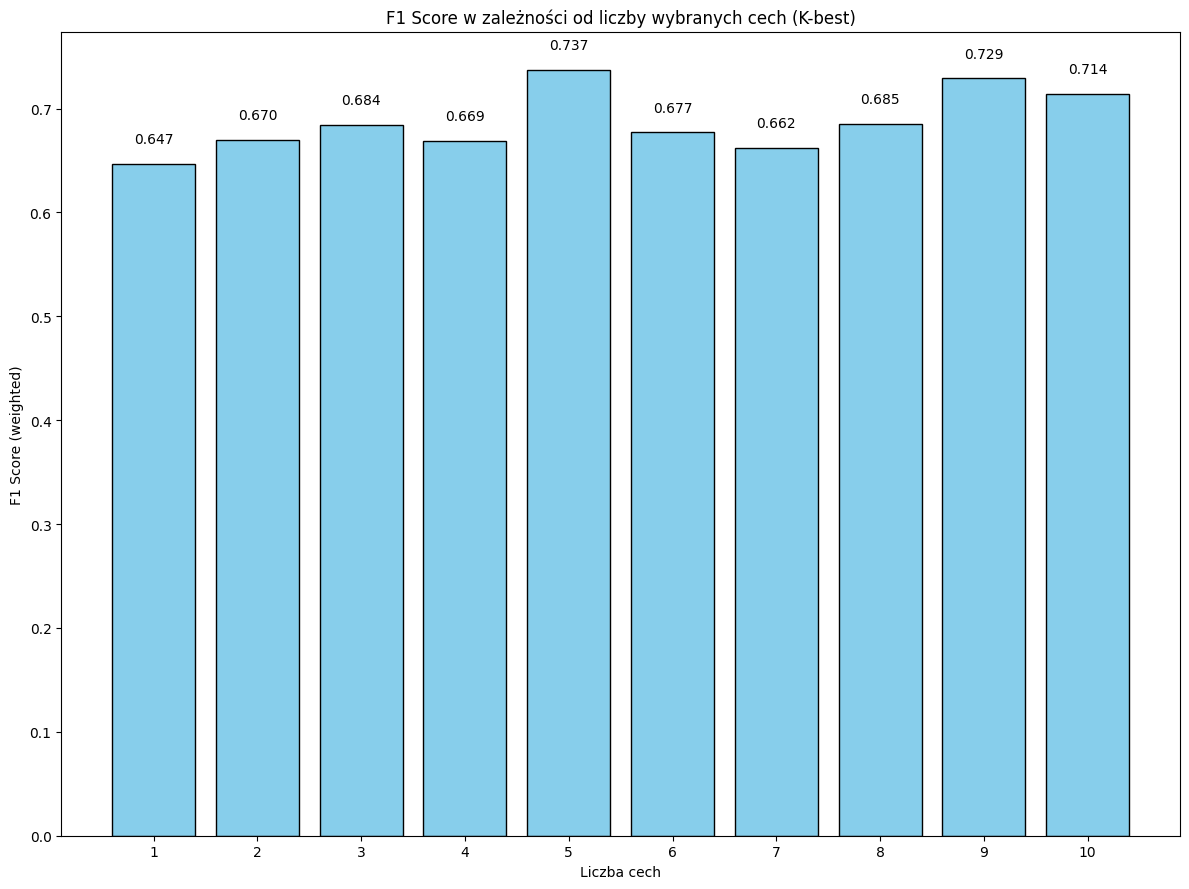

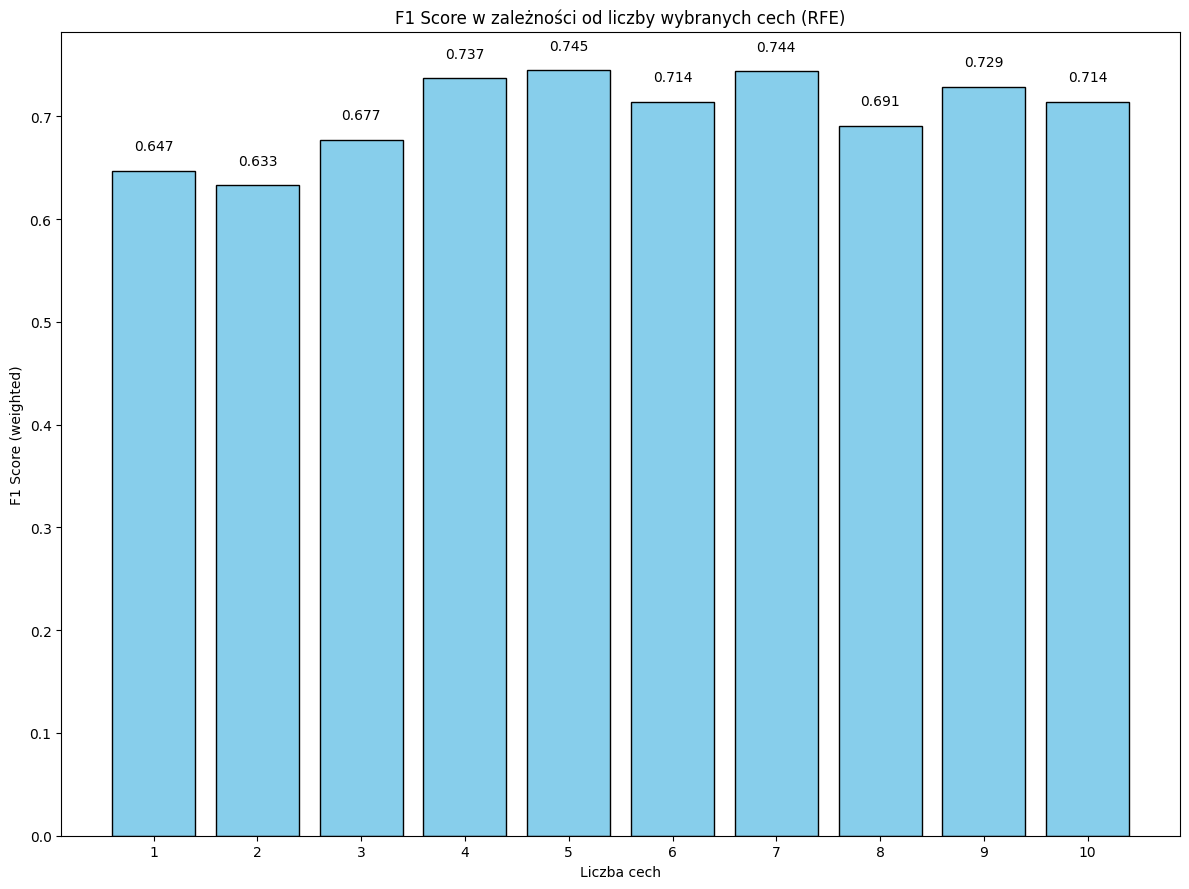

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


F1 Score (drzewo decyzyjne): 0.714


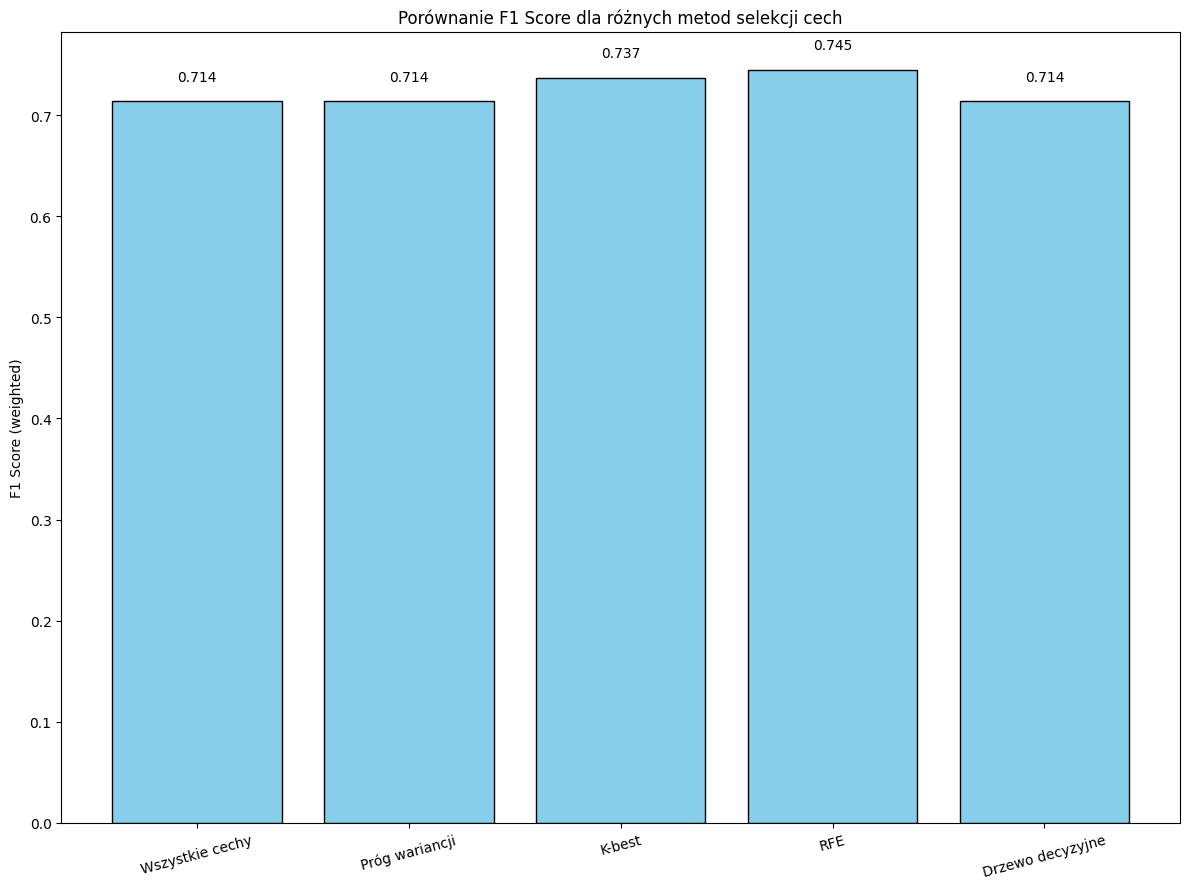

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import f1_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, mutual_info_classif, RFE, SelectFromModel
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns

%matplotlib inline
plt.rcParams["figure.figsize"] = (12, 9)

# Wczytaj dane
diabetes_data = load_diabetes()
diabetes_df = pd.DataFrame(data=diabetes_data.data, columns=diabetes_data.feature_names)
diabetes_df['target'] = (diabetes_data.target > diabetes_data.target.mean()).astype(int)  # Binarna klasyfikacja
diabetes_df.head()

# Rozkład zmiennej docelowej
sns.countplot(x='target', data=diabetes_df)
plt.title("Rozkład zmiennej docelowej")
plt.show()

# Przygotowanie danych
X = diabetes_df.drop(['target'], axis=1)
y = diabetes_df['target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, shuffle=True, stratify=y, random_state=42
)
print(f"Rozmiar treningowy: {X_train.shape}, Rozmiar testowy: {X_test.shape}")

# Model bazowy
gbc = GradientBoostingClassifier(max_depth=5, random_state=42)
gbc.fit(X_train, y_train)
preds = gbc.predict(X_test)
f1_score_all = round(f1_score(y_test, preds, average='weighted'), 3)
print(f"F1 Score (wszystkie cechy): {f1_score_all}")

# Feature Selection: Variance Threshold
scaler = MinMaxScaler()
scaled_X_train = scaler.fit_transform(X_train)
variances = pd.Series(scaled_X_train.var(axis=0), index=X.columns)
variances.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Wariancja cech po skalowaniu")
plt.xlabel("Cechy")
plt.ylabel("Wariancja")
for i, v in enumerate(variances):
    plt.text(i, v + 0.0005, f"{v:.4f}", ha='center')
plt.tight_layout()
plt.show()

low_variance_features = variances[variances < 0.01].index
sel_X_train_v1 = X_train.drop(columns=low_variance_features)
sel_X_test_v1 = X_test.drop(columns=low_variance_features)

gbc.fit(sel_X_train_v1, y_train)
var_preds = gbc.predict(sel_X_test_v1)
f1_score_var = round(f1_score(y_test, var_preds, average='weighted'), 3)
print(f"F1 Score (próg wariancji): {f1_score_var}")

# Feature Selection: K-best (mutual information)
f1_score_list = []
for k in range(1, X.shape[1] + 1):
    selector = SelectKBest(mutual_info_classif, k=k)
    sel_X_train_v2 = selector.fit_transform(X_train, y_train)
    sel_X_test_v2 = selector.transform(X_test)
    gbc.fit(sel_X_train_v2, y_train)
    preds = gbc.predict(sel_X_test_v2)
    f1_score_list.append(round(f1_score(y_test, preds, average='weighted'), 3))

# Wykres słupkowy dla K-best
fig, ax = plt.subplots()
ax.bar(range(1, X.shape[1] + 1), f1_score_list, color='skyblue', edgecolor='black')
ax.set_title("F1 Score w zależności od liczby wybranych cech (K-best)")
ax.set_xlabel("Liczba cech")
ax.set_ylabel("F1 Score (weighted)")
ax.set_xticks(range(1, X.shape[1] + 1))
for i, v in enumerate(f1_score_list):
    ax.text(i + 1, v + 0.02, f"{v:.3f}", ha='center')
plt.tight_layout()
plt.show()

# Recursive Feature Elimination (RFE)
f1_rfe_list = []
for k in range(1, X.shape[1] + 1):
    rfe = RFE(estimator=gbc, n_features_to_select=k)
    sel_X_train_v3 = rfe.fit_transform(X_train, y_train)
    sel_X_test_v3 = rfe.transform(X_test)
    gbc.fit(sel_X_train_v3, y_train)
    preds = gbc.predict(sel_X_test_v3)
    f1_rfe_list.append(round(f1_score(y_test, preds, average='weighted'), 3))

# Wykres słupkowy dla RFE
fig, ax = plt.subplots()
ax.bar(range(1, X.shape[1] + 1), f1_rfe_list, color='skyblue', edgecolor='black')
ax.set_title("F1 Score w zależności od liczby wybranych cech (RFE)")
ax.set_xlabel("Liczba cech")
ax.set_ylabel("F1 Score (weighted)")
ax.set_xticks(range(1, X.shape[1] + 1))
for i, v in enumerate(f1_rfe_list):
    ax.text(i + 1, v + 0.02, f"{v:.3f}", ha='center')
plt.tight_layout()
plt.show()

# SelectFromModel z drzewem decyzyjnym
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)
threshold = 0.01
selector = SelectFromModel(dt, threshold=threshold, prefit=True)
sel_X_train_v4 = selector.transform(X_train)
sel_X_test_v4 = selector.transform(X_test)

gbc.fit(sel_X_train_v4, y_train)
preds = gbc.predict(sel_X_test_v4)
f1_score_dt = round(f1_score(y_test, preds, average='weighted'), 3)
print(f"F1 Score (drzewo decyzyjne): {f1_score_dt}")

# Podsumowanie wyników
methods = ['Wszystkie cechy', 'Próg wariancji', 'K-best', 'RFE', 'Drzewo decyzyjne']
scores = [f1_score_all, f1_score_var, max(f1_score_list), max(f1_rfe_list), f1_score_dt]
fig, ax = plt.subplots()
ax.bar(methods, scores, color='skyblue', edgecolor='black')
ax.set_title("Porównanie F1 Score dla różnych metod selekcji cech")
ax.set_ylabel("F1 Score (weighted)")
ax.set_xticks(range(len(methods)))
ax.set_xticklabels(methods, rotation=15)
for i, v in enumerate(scores):
    ax.text(i, v + 0.02, f"{v:.3f}", ha='center')
plt.tight_layout()
plt.show()